In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Required Libraries

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.linear_model import LogisticRegression

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# SMOTE
from imblearn.over_sampling import SMOTE

In [ ]:
#Load dataset

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cicddos2019_dataset.csv')
df.head()

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,0,17,216631,6,0,2088.0,0.0,393.0,321.0,348.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
1,1,17,2,2,0,802.0,0.0,401.0,401.0,401.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
2,2,17,48,2,0,766.0,0.0,383.0,383.0,383.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
3,3,17,107319,4,0,1398.0,0.0,369.0,330.0,349.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
4,4,17,107271,4,0,1438.0,0.0,389.0,330.0,359.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack


In [ ]:
# Data Preprocessing

In [ ]:
# Binary comvertion

In [4]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

print(df['Label'].value_counts())

Label
1    333540
0     97831
Name: count, dtype: int64


In [5]:
X = df.drop(columns=['Label'])
y = df['Label']

In [6]:
X = X.select_dtypes(include=[np.number])

In [ ]:
#Handling missing values

In [7]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

In [ ]:
# Normalization

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Feature Selection using RFE

In [12]:
lr = LogisticRegression(max_iter=3000)
rfe = RFE(lr, n_features_to_select=20)
rfe.fit(X_scaled, y)

rfe_features = X.columns[rfe.support_]
print("Top 20 RFE Features:\n", rfe_features)

Top 20 RFE Features:
 Index(['Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Variance', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'Avg Packet Size',
       'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Init Bwd Win Bytes',
       'Active Min'],
      dtype='object')


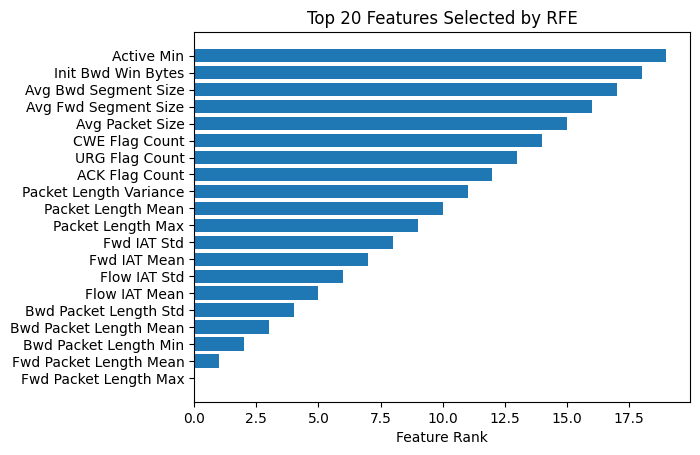

In [13]:
plt.figure()
plt.barh(rfe_features, range(20))
plt.xlabel("Feature Rank")
plt.title("Top 20 Features Selected by RFE")
plt.show()

In [ ]:
# Feature Selection using MI

In [14]:
mi_scores = mutual_info_classif(X_scaled, y)
mi_df = pd.DataFrame({
    "Feature": X.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

mi_features = mi_df.head(20)["Feature"].values
print("Top 20 MI Features:\n", mi_features)

Top 20 MI Features:
 ['Avg Packet Size' 'Packet Length Mean' 'Avg Fwd Segment Size'
 'Fwd Packet Length Mean' 'Packet Length Min' 'Fwd Packet Length Min'
 'Packet Length Max' 'Subflow Fwd Bytes' 'Fwd Packets Length Total'
 'Fwd Packet Length Max' 'Flow Bytes/s' 'Flow IAT Mean' 'Flow Packets/s'
 'Flow IAT Max' 'Fwd Packets/s' 'Bwd Packets/s' 'Flow IAT Std'
 'Fwd IAT Max' 'Fwd IAT Mean' 'Flow Duration']


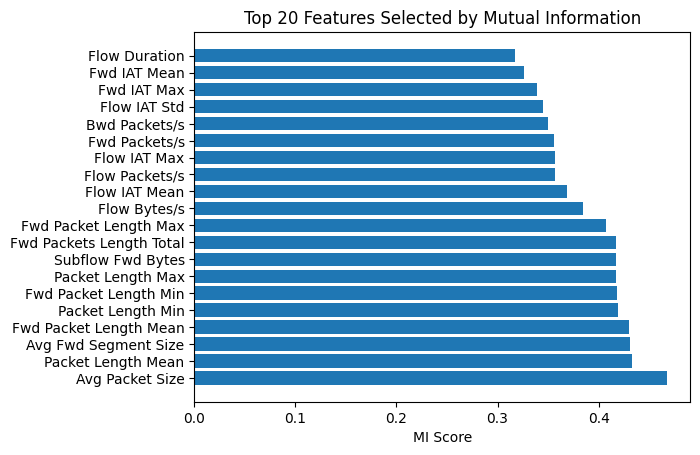

In [15]:
plt.figure()
plt.barh(mi_df.head(20)['Feature'], mi_df.head(20)['MI_Score'])
plt.xlabel("MI Score")
plt.title("Top 20 Features Selected by Mutual Information")
plt.show()

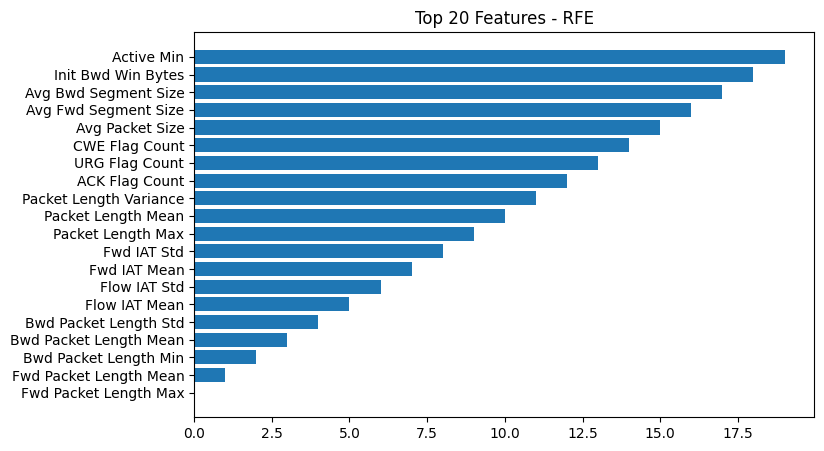

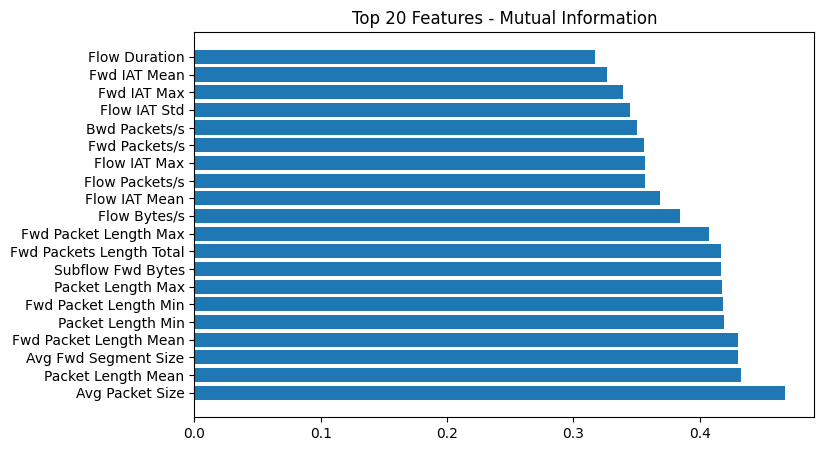

In [16]:
plt.figure(figsize=(8,5))
plt.barh(rfe_features, range(20))
plt.title("Top 20 Features - RFE")
plt.show()

plt.figure(figsize=(8,5))
plt.barh(mi_df.head(20)['Feature'], mi_df.head(20)['MI_Score'])
plt.title("Top 20 Features - Mutual Information")
plt.show()

In [ ]:
 # Data balancing using Smote

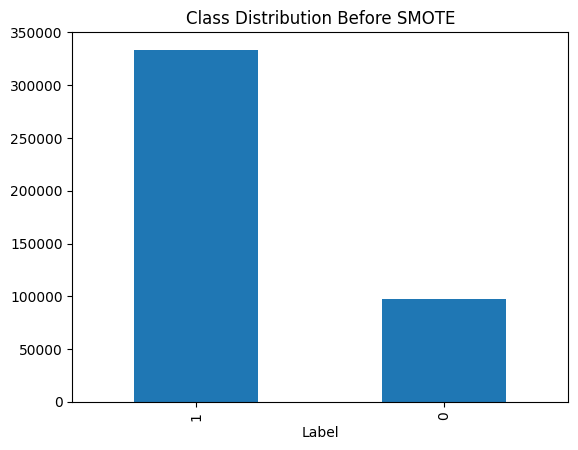

In [17]:
y.value_counts().plot(kind='bar')
plt.title("Class Distribution Before SMOTE")
plt.show()

In [18]:
smote = SMOTE(random_state=42)
X_rfe_smote, y_rfe_smote = smote.fit_resample(X_scaled[rfe_features], y)
X_mi_smote, y_mi_smote = smote.fit_resample(X_scaled[mi_features], y)

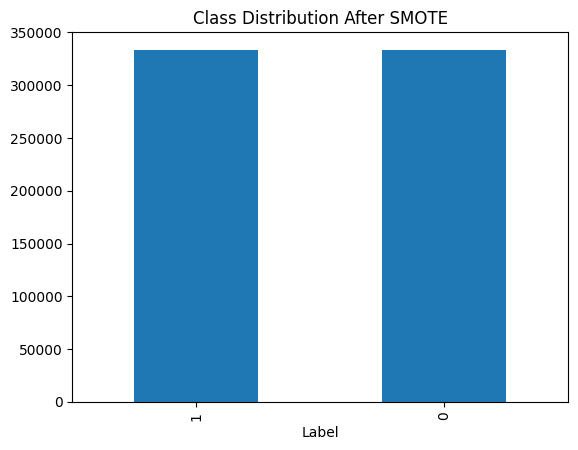

In [19]:
pd.Series(y_rfe_smote).value_counts().plot(kind='bar')
plt.title("Class Distribution After SMOTE")
plt.show()

In [ ]:
#Data splitting

In [20]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_rfe_smote, y_rfe_smote, test_size=0.2, random_state=42
)

Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_mi_smote, y_mi_smote, test_size=0.2, random_state=42
)

In [ ]:
# Models

In [21]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

In [ ]:
# Evaluation function

In [23]:

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

In [ ]:
# Run models using RFE and MI

In [ ]:
results = []

for name, model in models.items():
    # RFE
    rfe_res = evaluate_model(model, Xr_train, Xr_test, yr_train, yr_test)
    rfe_res['Model'] = name
    rfe_res['Feature_Selection'] = 'RFE'
    results.append(rfe_res)

    # MI
    mi_res = evaluate_model(model, Xm_train, Xm_test, ym_train, ym_test)
    mi_res['Model'] = name
    mi_res['Feature_Selection'] = 'MI'
    results.append(mi_res)

results_df = pd.DataFrame(results)
results_df